In [2]:
from ps_utils import read_data_file, unbiased_integrate, display_surface, ransac_3dvector, smooth_normal_field, simchony_integrate
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize as rz
%pylab inline
pylab.rcParams['figure.figsize'] = (12,6)

Populating the interactive namespace from numpy and matplotlib


In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

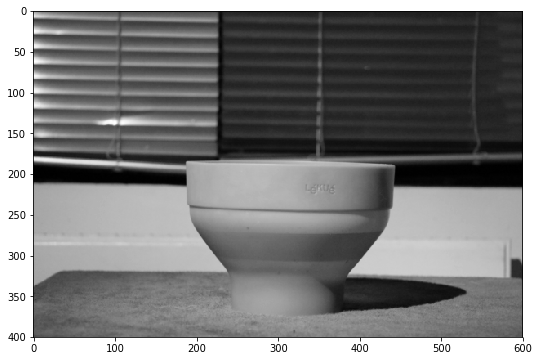

(400, 600)


In [4]:
img1 = rz(rgb2gray(plt.imread('PMS/img1.JPG')), (400, 600), anti_aliasing=True)
img2 = rz(rgb2gray(plt.imread('PMS/img2.JPG')), (400, 600), anti_aliasing=True)
img3 = rz(rgb2gray(plt.imread('PMS/img3.JPG')), (400, 600), anti_aliasing=True)
img4 = rz(rgb2gray(plt.imread('PMS/img4.JPG')), (400, 600), anti_aliasing=True)
img5 = rz(rgb2gray(plt.imread('PMS/img5.JPG')), (400, 600), anti_aliasing=True)
img6 = rz(rgb2gray(plt.imread('PMS/img6.JPG')), (400, 600), anti_aliasing=True)
img7 = rz(rgb2gray(plt.imread('PMS/img7.JPG')), (400, 600), anti_aliasing=True)
img8 = rz(rgb2gray(plt.imread('PMS/img8.JPG')), (400, 600), anti_aliasing=True)
img9 = rz(rgb2gray(plt.imread('PMS/img9.JPG')), (400, 600), anti_aliasing=True)
img10 = rz(rgb2gray(plt.imread('PMS/img10.JPG')), (400, 600), anti_aliasing=True)
mask = rz(rgb2gray(plt.imread('PMS/bwmask.JPG')), (400, 600), anti_aliasing=True)
S = np.array([[1.3,1.4,1.5], [0.72,1.4,1.5], [-0.44,1.4,1.5], [-1.03, 1.4,1.5], [-1.03,0.42,1.5], [-0.44,0.42,1.5], [0.72,0.42,1.5], [1.3,0.42,1.5], [-0.44,-0.18,1.5], [0.72,-0.18,1.5]])
plt.imshow(img1, cmap='gray')
plt.show()
print(img1.shape)

In [ ]:
m_flat = mask.flatten()

for i in range(len(m_flat)):
    if (m_flat[i] > 200):
        m_flat[i] = 1
    else:
        m_flat[i] = 0
        
m_flat = m_flat.astype(int)
    
nz = np.sum(m_flat)
J = np.zeros((10,nz))

j = 0
i_all = np.vstack((img1.flatten(), img2.flatten(), img3.flatten(), img4.flatten(), 
                   img5.flatten(), img6.flatten(), img7.flatten(), img8.flatten(),
                   img9.flatten(), img10.flatten()))
for i in range(len(img1.flatten())):
    if m_flat[i]:
        J[0,j] = i_all[0,i]
        J[1,j] = i_all[1,i]
        J[2,j] = i_all[2,i]
        J[3,j] = i_all[3,i]
        J[4,j] = i_all[4,i]
        J[5,j] = i_all[5,i]
        J[6,j] = i_all[6,i]
        J[7,j] = i_all[7,i]
        J[8,j] = i_all[8,i]
        J[9,j] = i_all[9,i]
        j += 1
        
######### Pseudo Inverse - Woodham's Solution #########
# m = np.linalg.pinv(S)
# print(m.shape)
# M = m @ J
# M1 = M[0]
# M2 = M[1]
# M3 = M[2]
# rho = np.sqrt(M1**2 + M2**2 + M3**2)
# n0 = M1 / rho
# n1 = M2 / rho
# n2 = M3 / rho

######### RANSAC Solution #########
rho = np.ndarray(nz)
n0 = np.ndarray(nz)
n1 = np.ndarray(nz)
n2 = np.ndarray(nz)
for i in range(nz):
    tmp = np.array([J[0,i], J[1,i], J[2,i], J[3,i], J[4,i], J[5,i], J[6,i], J[7,i], J[8,i], J[9,i]])
    m, inliers, best_fit = ransac_3dvector((tmp, S), 100.0, verbose=0)
    norm = np.sqrt(m[0]**2 + m[1]**2 + m[2]**2)
    rho[i] = norm
    n0[i] = m[0] / norm
    n1[i] = m[1] / norm
    n2[i] = m[2] / norm

j = 0
img = np.ndarray(400 * 600)
N0 = np.ndarray(400 * 600)
N1 = np.ndarray(400 * 600)
N2 = np.ndarray(400 * 600)
for i in range(len(img)):
    if m_flat[i]:
        img[i] = rho[j]
        N0[i] = n0[j]
        N1[i] = n1[j]
        N2[i] = n2[j]
        j += 1
    else:
        img[i] = 0
        N0[i] = 0
        N1[i] = 0
        N2[i] = 0

albedo = img.reshape((400, 600))
plt.imshow(albedo, cmap='gray')

N0 = N0.reshape(400,600)
N1 = N1.reshape(400,600)
N2 = N2.reshape(400,600)
N0, N1, N2 = smooth_normal_field(N0, N1, N2, mask)
model = unbiased_integrate(N0, N1, N2, mask)

print('Mayavi waiting...')
display_surface(model)